
Rodada 1 da Apuração:
     Candidato  Total
0  Candidato 2      4
1  Candidato 5      4
2  Candidato 1      1
3  Candidato 3      1

O candidato Candidato 1 foi eliminado.

Rodada 2 da Apuração:
     Candidato  Total
0  Candidato 2      4
1  Candidato 5      4
2  Candidato 3      1

O candidato Candidato 3 foi eliminado.

Rodada 3 da Apuração:
     Candidato  Total
0  Candidato 2      4
1  Candidato 5      4

O candidato Candidato 2 foi eliminado.

O candidato Candidato 5 venceu por eliminação!


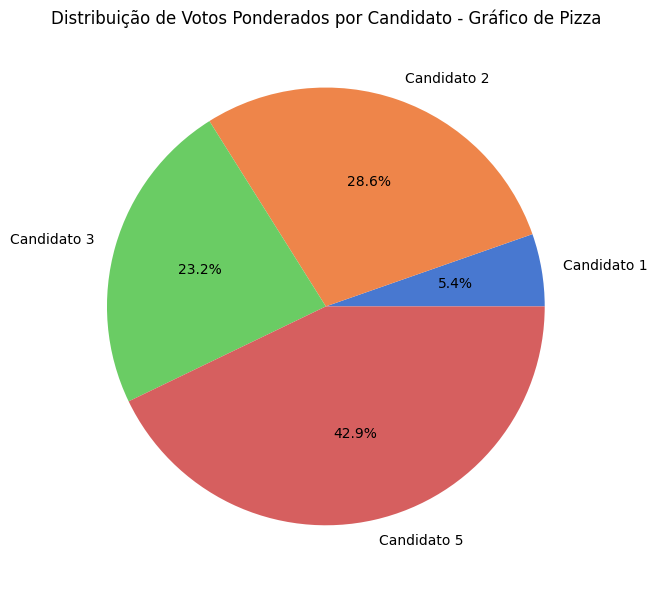

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gspread
from google.auth import default
from google.colab import auth

# Autenticação no Google Colab para acessar o Google Sheets
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Abrir a planilha pelo URL
planilha = gc.open_by_url('https://docs.google.com/spreadsheets/d/1ytpaYCOamhSLdSWA3rgxbCFufyzMO90YRz54YI55SCM/edit#gid=1340807461')

# Selecionar a aba da planilha (se necessário)
aba = planilha.sheet1

# Carregar os dados da aba em um DataFrame
df = pd.DataFrame(aba.get_all_records())

# Identificar as colunas de candidatos
colunas_candidatos = df.columns[1:-1]  # Exclui Timestamp e Email Address

# Preencher valores ausentes com '0000' (votos nulos) para as colunas de candidatos
df[colunas_candidatos] = df[colunas_candidatos].fillna('0000')

# Converter as colunas de candidatos para string (caso não estejam)
df[colunas_candidatos] = df[colunas_candidatos].astype(str)

# Função para realizar a apuração de votação preferencial
def apuracao_votacao_preferencial(df_votos):
    candidatos = sorted(list(set(df_votos[colunas_candidatos[0]])))
    num_eleitores = len(df_votos)
    rodada = 1

    while len(candidatos) > 1:
        print(f"\nRodada {rodada} da Apuração:")

        # Calcular os totais de votos da rodada
        totais = df_votos[colunas_candidatos[0]].value_counts().to_dict()

        if not totais:
            print("\nNenhum voto restante. Apuração encerrada.")
            return None

        # Criar um DataFrame para exibir os resultados da rodada
        resultados_rodada = pd.DataFrame(list(totais.items()), columns=['Candidato', 'Total'])
        print(resultados_rodada)

        # Verificar se algum candidato atingiu a maioria absoluta
        maior_votos = max(totais.values())
        if maior_votos > num_eleitores / 2:
            vencedor = resultados_rodada.loc[resultados_rodada['Total'] == maior_votos, 'Candidato'].values[0]
            print(f"\nO candidato {vencedor} venceu a eleição na rodada {rodada}!")
            return vencedor

        # Encontrar o candidato com o menor número de votos
        menor_votos = min(totais.values())
        candidatos_menor_voto = [c for c, v in totais.items() if v == menor_votos]
        candidato_eliminado = candidatos_menor_voto[0]  # Elimina o primeiro em caso de empate

        print(f"\nO candidato {candidato_eliminado} foi eliminado.")

        # Remover o candidato eliminado da lista de candidatos
        candidatos.remove(candidato_eliminado)

        # Redistribuir os votos do candidato eliminado
        df_votos = df_votos[df_votos[colunas_candidatos[0]] != candidato_eliminado]

        # Ajustar as preferências dos eleitores que votaram no candidato eliminado
        for index, row in df_votos.iterrows():
            for i in range(len(colunas_candidatos) - 1):
                if row[colunas_candidatos[i]] == candidato_eliminado:
                    df_votos.loc[index, colunas_candidatos[i]] = row[colunas_candidatos[i+1]]
                    df_votos.loc[index, colunas_candidatos[i+1]] = '0000'  # Representa um voto nulo após a redistribuição

        rodada += 1

    # Se restar apenas um candidato, ele é o vencedor
    if len(candidatos) == 1:
        vencedor = candidatos[0]
        print(f"\nO candidato {vencedor} venceu por eliminação!")
        return vencedor

    print("\nA apuração não encontrou um vencedor.")
    return None

# Realizar a apuração da votação
vencedor = apuracao_votacao_preferencial(df.copy())

# Função para calcular os totais de votos com base nas preferências dos eleitores
def calcular_totais(voting_df):
    """
    Calcula o total ponderado de votos para cada candidato com base nas preferências
    dos eleitores. A primeira escolha recebe o peso mais alto (número de candidatos),
    a segunda um peso menor, e assim por diante.
    """
    candidatos = sorted(list(set(voting_df[colunas_candidatos[0]])))
    resultados = {candidato: 0 for candidato in candidatos}
    pesos = list(range(len(colunas_candidatos), 0, -1))

    for _, row in voting_df.iterrows():
        for i, coluna in enumerate(colunas_candidatos):
            candidato = row[coluna]
            if candidato in resultados and candidato != '0000':
                resultados[candidato] += pesos[i]

    return pd.DataFrame(list(resultados.items()), columns=['Candidato', 'Total'])

# Calcular o total de votos para cada candidato
resultado = calcular_totais(df)

# Visualizar os resultados da votação com três gráficos

## Gráfico de pizza (remover candidatos com 0 votos)
resultado_pie = resultado[resultado['Total'] > 0]

plt.figure(figsize=(8, 6))
plt.pie(resultado_pie['Total'], labels=resultado_pie['Candidato'], autopct='%1.1f%%', colors=sns.color_palette('muted'))
plt.title('Distribuição de Votos Ponderados por Candidato - Gráfico de Pizza')
plt.tight_layout()
plt.show()